In [ ]:
# %%

from datasets import load_dataset

dataset = load_dataset('EgoThink/EgoThink', 'Activity', trust_remote_code=True)
dataset = dataset['test']
images = [dataset[i]['image'] for i in range(100)]

In [ ]:
# %%

import numpy as np
from PIL import Image
import torch

def transform_image(image, resolution=(1024, 1024)):
    image = image.convert('RGB').resize(resolution, Image.LANCZOS)
    # Convert to torch tensor
    image = torch.tensor(np.array(image).transpose(2, 0, 1)).float()
    image = image / 255
    # Normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - torch.tensor(mean).view(3, 1, 1)) / torch.tensor(std).view(3, 1, 1)
    return image

In [ ]:
# %%

images_tsf = torch.stack([transform_image(img) for img in images])

In [ ]:
# %%

from ncut_pytorch import NCUT, rgb_from_tsne_3d
from ncut_pytorch.backbone import load_model, extract_features

model = load_model(model_name="SAM(sam_vit_b)")
model_features = extract_features(images_tsf, model, node_type='attn', layer=11, batch_size=4)
# model_features = model(images_tsf)['attn'][11]  # this also works

num_eig = 30
inp = model_features.reshape(-1, 768) # flatten
eigvectors, eigvalues = NCUT(num_eig=num_eig, device='cuda:0').fit_transform(inp)
tsne_x3d, tsne_rgb = rgb_from_tsne_3d(eigvectors, device='cuda:0')

eigvectors = eigvectors.reshape(-1, 64, 64, num_eig) # (B, H, W, num_eig)
tsne_rgb = tsne_rgb.reshape(-1, 64, 64, 3) # (B, H, W, 3)

Loaded SAM(sam_vit_b), please use input resolution: (1024, 1024)


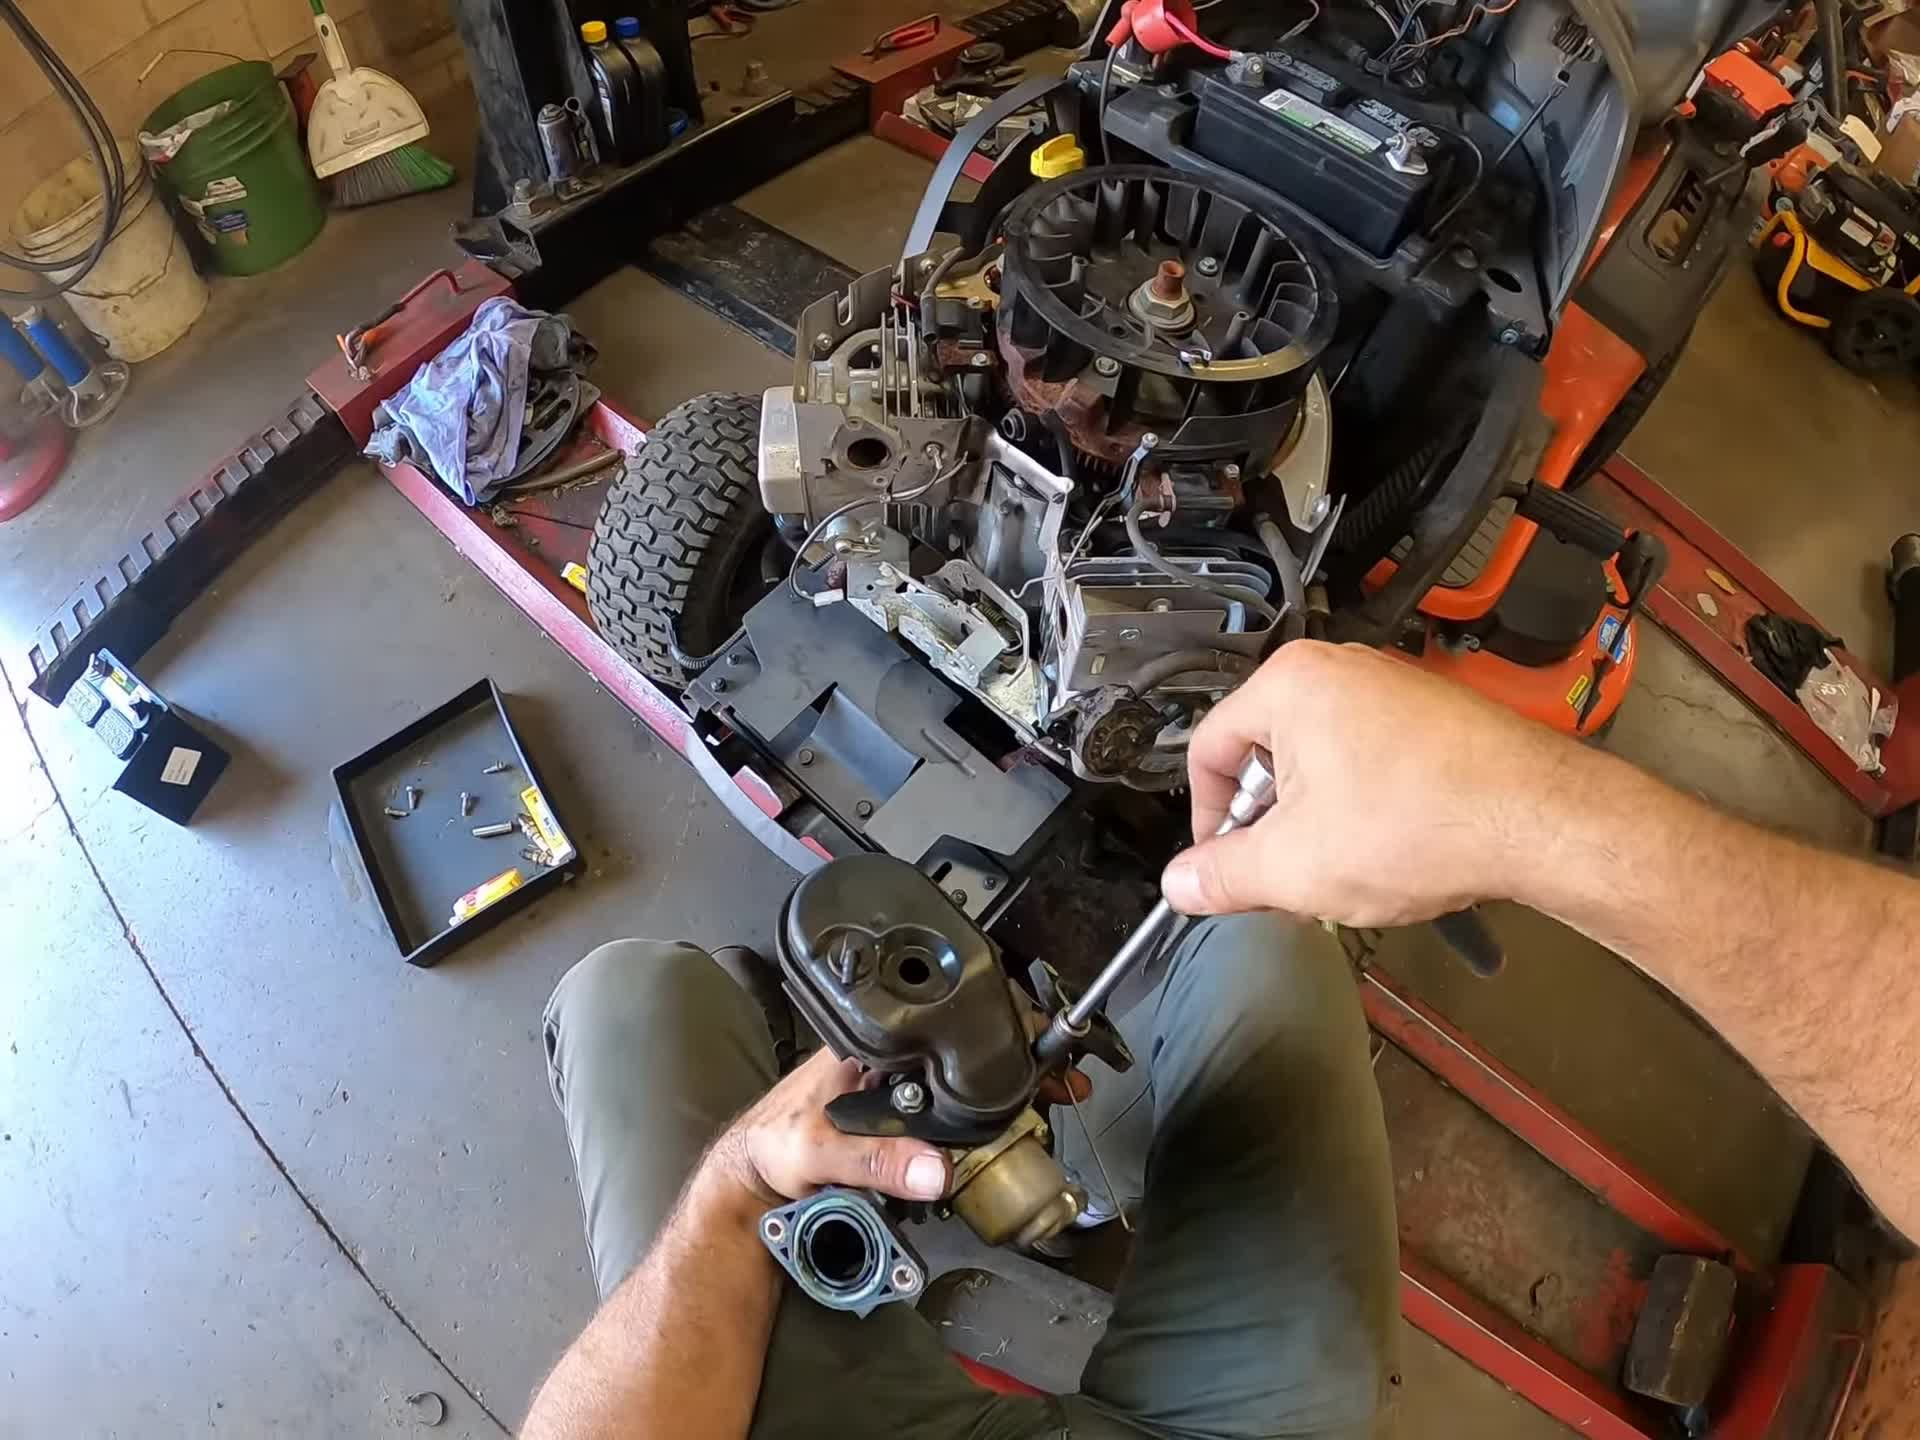

In [ ]:
# %%

# display the first image, 
image = images[0]
image

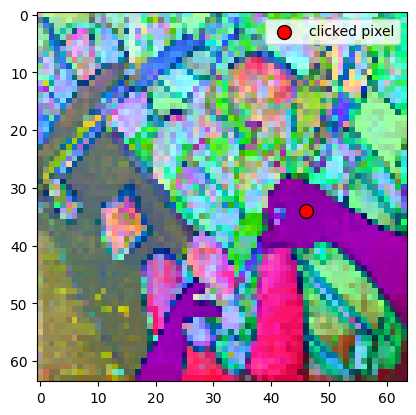

In [ ]:
# %%

x1, x2 = 34, 46
clicked_eigvec = eigvectors[0, x1, x2]  # hand pixel
import matplotlib.pyplot as plt
# display the clicked pixel on the tsne_rgb image
plt.imshow(tsne_rgb[0])
plt.scatter(x2, x1, c='red', s=100, label='clicked pixel', edgecolors='black')
plt.legend()
plt.show()

In [ ]:
# %%

from ncut_pytorch.ncut_pytorch import get_mask
masks = get_mask(eigvectors, clicked_eigvec, threshold=0.5, gamma=1.0, denoise=True, denoise_area_th=3)
"""Segmentation mask from one prompt eigenvector (at a clicked latent pixel).
    </br> The mask is computed by measuring the cosine similarity between the clicked eigenvector and all the eigenvectors in the latent space.
    </br> 1. Compute the cosine similarity between the clicked eigenvector and all the eigenvectors in the latent space.
    </br> 2. Transform the heatmap, normalize and apply scaling (gamma).
    </br> 3. Threshold the heatmap to get the mask.
    </br> 4. Optionally denoise the mask by removing small connected components
    
Args:
    all_eigvecs (torch.Tensor): (B, H, W, num_eig)
    prompt_eigvec (torch.Tensor): (num_eig,)
    threshold (float, optional): mask threshold, higher means smaller mask. Defaults to 0.5.
    gamma (float, optional): mask scaling factor, higher means smaller mask. Defaults to 1.0.
    denoise (bool, optional): mask denoising flag. Defaults to True.
    denoise_area_th (int, optional): mask denoising area threshold. higher means more aggressive denoising. Defaults to 3.

Returns:
    np.ndarray: masks (B, H, W), 1 for object, 0 for background
    
Examples:
    >>> all_eigvecs = torch.randn(10, 64, 64, 20)
    >>> prompt_eigvec = all_eigvecs[0, 32, 32]  # center pixel
    >>> masks = get_mask(all_eigvecs, prompt_eigvec, threshold=0.5, gamma=1.0, denoise=True, denoise_area_th=3)
    >>> # masks.shape = (10, 64, 64)
"""

'Segmentation mask from one prompt eigenvector (at a clicked latent pixel).\n    </br> The mask is computed by measuring the cosine similarity between the clicked eigenvector and all the eigenvectors in the latent space.\n    </br> 1. Compute the cosine similarity between the clicked eigenvector and all the eigenvectors in the latent space.\n    </br> 2. Transform the heatmap, normalize and apply scaling (gamma).\n    </br> 3. Threshold the heatmap to get the mask.\n    </br> 4. Optionally denoise the mask by removing small connected components\n    \nArgs:\n    all_eigvecs (torch.Tensor): (B, H, W, num_eig)\n    prompt_eigvec (torch.Tensor): (num_eig,)\n    threshold (float, optional): mask threshold, higher means smaller mask. Defaults to 0.5.\n    gamma (float, optional): mask scaling factor, higher means smaller mask. Defaults to 1.0.\n    denoise (bool, optional): mask denoising flag. Defaults to True.\n    denoise_area_th (int, optional): mask denoising area threshold. higher mea

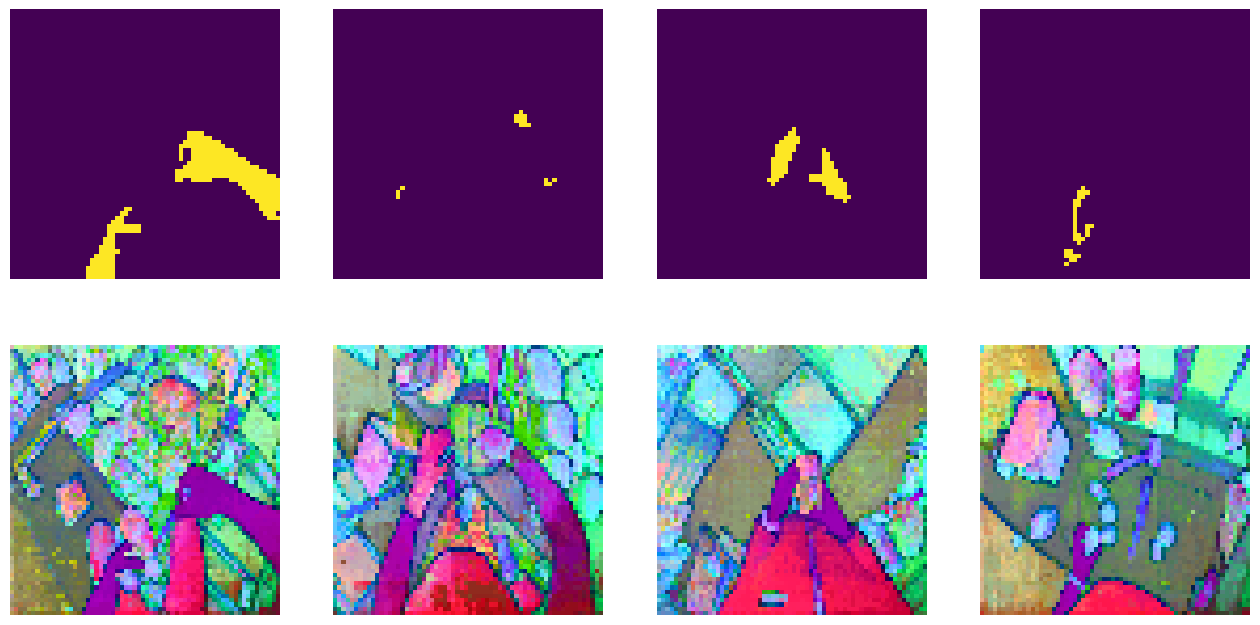

In [ ]:
# %%

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    axs[0, i].imshow(masks[i])
    axs[0, i].axis('off')
    axs[1, i].imshow(tsne_rgb[i])
    axs[1, i].axis('off')